# Seasonality

We wanted to survey BNF products with seasonal usage patterns so wanted a way of surfacing them.

We took a simple approach based on the discrete Fourier transform of the timeseries of monthly total items prescribed:

- extract from BigQuery the time series for all products
- for each product run FFT and select the products that have a dominant period in their spectrum
- plot results in descending order of maximum monthly items used:
 - plot the original timeseries of items used per month and year
 - box plot items used per month (merging same months in different years)
 - plot the FFT spectrum

In [2]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq,practice # my local stuff
from scipy.fftpack import fft
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


# Get the data from ebmdatalab project in BigQuery

See comments in gbq.py for how to configure using gcloud command line tool.

In [176]:
df=gbq.query(
    '''
    select TIMESTAMP_TO_MSEC(month) PERIOD,left(bnf_code,11) BNF_PRODUCT,sum(actual_cost) TOTAL_ACT_COST,sum(items) TOTAL_ITEMS
    from [hscic.prescribing]
    group by PERIOD,BNF_PRODUCT
    ''',
    max_rows=1000000,index=['BNF_PRODUCT','PERIOD'],
    cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float,'PERIOD':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Big Query returned in 155.16 seconds
Waiting on bqjob_r759427491d098085_000001528e286f2d_1 ... (49s) Current status: DONE   
794790 rows converted to DataFrame in 5.49 seconds


In [178]:
df.head()

,,TOTAL_ACT_COST,TOTAL_ITEMS
BNF_PRODUCT,PERIOD,,
090607000BB,2012-04-01 01:00:00,245947.60,53205
1302011M0BB,2012-04-01 01:00:00,24300.48,3144
1404000F0BL,2012-11-01 00:00:00,246673.91,40566
0601022B0AA,2015-04-01 01:00:00,9082684.88,1570267
0407041A0BI,2014-10-01 01:00:00,5497.97,472


# Apply the scoring

Run FFT and look for a dominant period (ignoring the constant component) which is not to short or long.

I've taken a dominant period to be one (i) with the maximum amplitude and (ii) for which its amplitude exceeds the next biggest by some factor, eg 1.5

In [187]:
def score(ts):
    # number of whole years spanned in the timeseries (measured in months)
    n=12*int(len(ts)/12)
    if n>24: # only consider time series longer than 2 years
        ksorted=sorted([(np.abs(x),k) for k,x in enumerate(fft(ts[-n:]))][1:n/2],reverse=True)
        if ksorted[0][1]>4 and ksorted[0][1]<16 and ksorted[0][0]/ksorted[1][0]>1.5:
            return np.max(ts)
        else:
            return 0
    else:
        return 0

In [188]:
#NB must sort index of df, as the score function assumes values are organised in time order (groupby preserves the order)
scores=df.sort().groupby(level=0).agg(score)

In [189]:
from matplotlib import gridspec
from IPython.display import HTML
def plot_with_spectrum(ts,bnfcoords):
    
    display(HTML("%s (%s)" % (bnf.description(bnfcoords),bnfcoords)))
    
    n=12*int(len(ts)/12)
    ts2=ts.sort()[-n:]

    fig = plt.figure(figsize=(18,4))
    gs = gridspec.GridSpec(1,3,width_ratios=[2,1,1])
    axes=map(plt.subplot,gs)
    
    ax=ts2[['TOTAL_ITEMS']].plot(ylim=0,linewidth=2,
                #secondary_y=['TOTAL_ACT_COST'],
                ax=axes[0],title='Time series')
    #ax.right_ax.set_ylim(0)
    
    fts=fft(ts2['TOTAL_ITEMS'])
    axes[2].set_title('Spectrum')
    axes[2].plot(range(1,n/2),[np.abs(k) for k in fts][1:n/2],color='m',linewidth=2)
    
    ts3=pd.DataFrame(ts2,copy=True)
    ts3.index=pd.MultiIndex.from_tuples(ts3.index.map(lambda t: (t.year,t.month)),names=['year','month'])
    ts3.unstack()['TOTAL_ITEMS'].plot(kind='box',ax=axes[1],title="Monthly variation",ylim=0)
    
    show()
    

## Plots

Here I include only plot products with a score of at least 5000. This means they are seasonal and have a peak that is at least 5000 items used per month.

### Monthly variation plot

Months of different years are identified, and the data for each of the years presented as a box. (We ony have 5 years, so we could alternatively plot each one separately).

### Spectrum plot

The x-axis of the specturm plots is wave number, i.e. how many times the period of the signal fits into the entire time period. Since most (if not all) plots span 5 years:

- a spectrum spiking at wave number 5 means a dominant periodicity of 1 year
- a spectrum spiking at wave number 15 means a dominant periodicity of 4 months

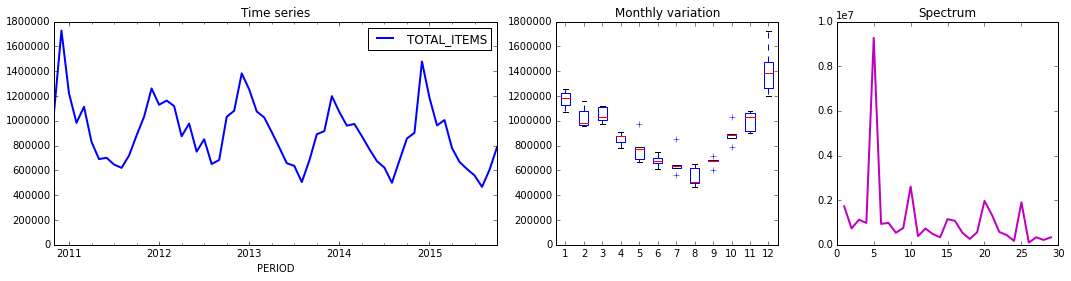

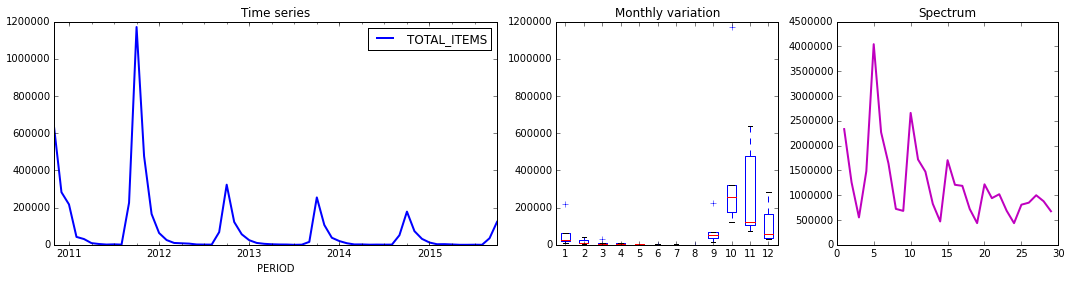

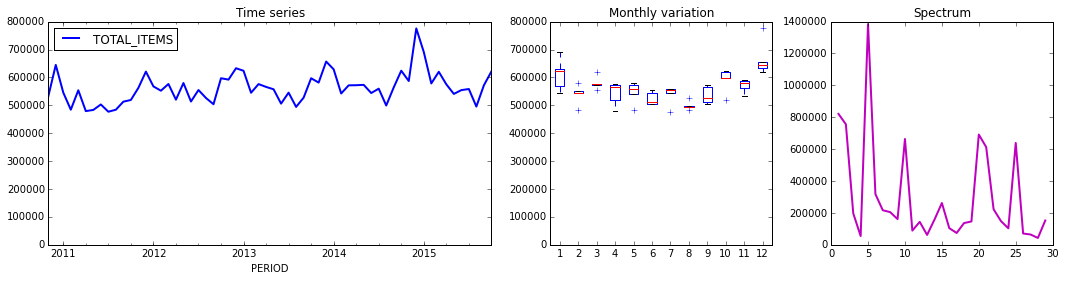

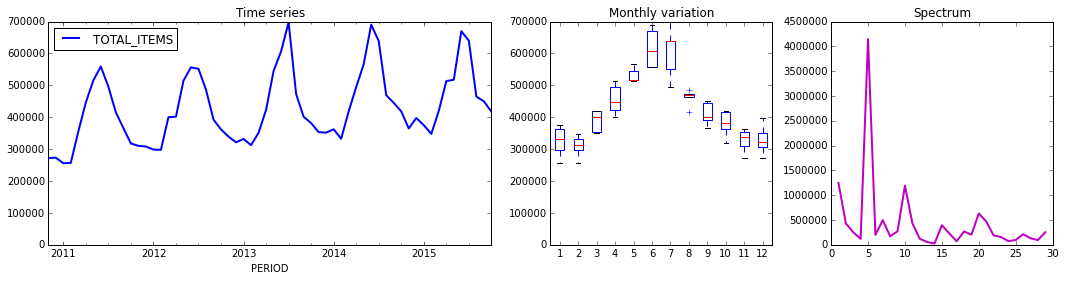

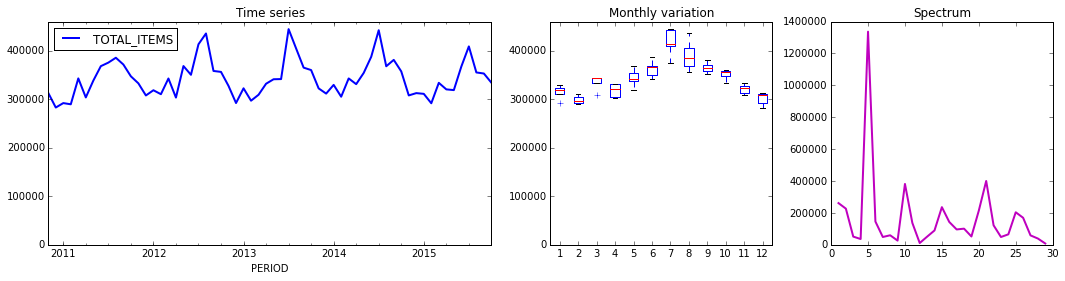

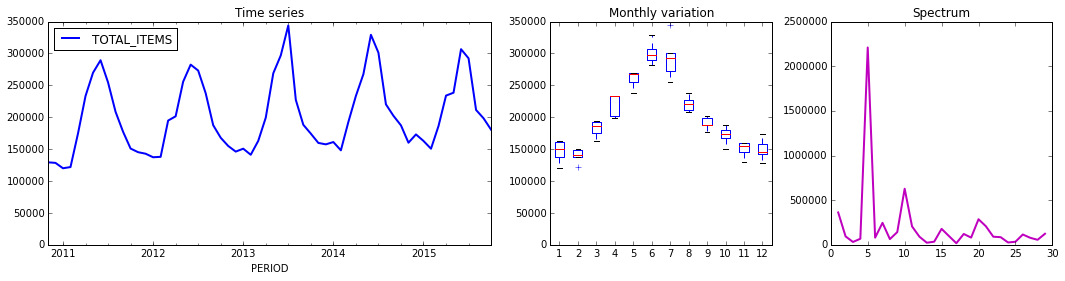

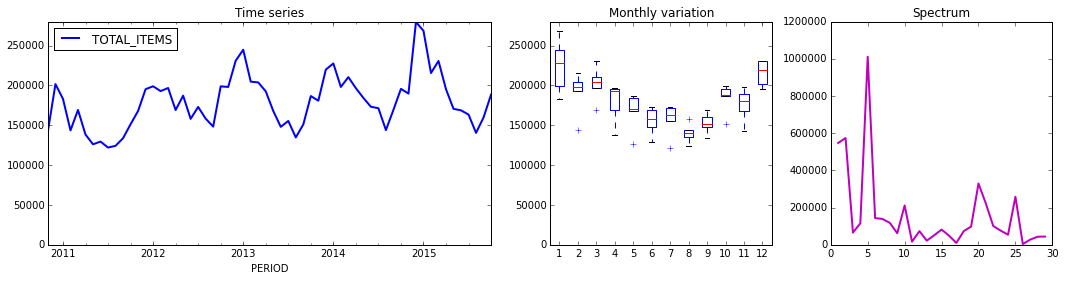

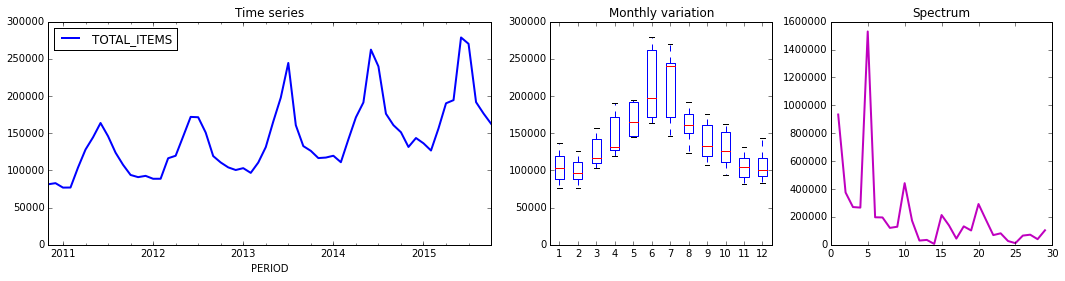

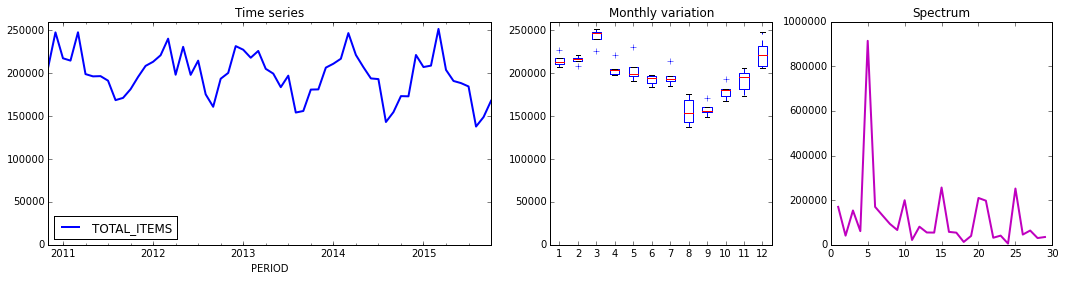

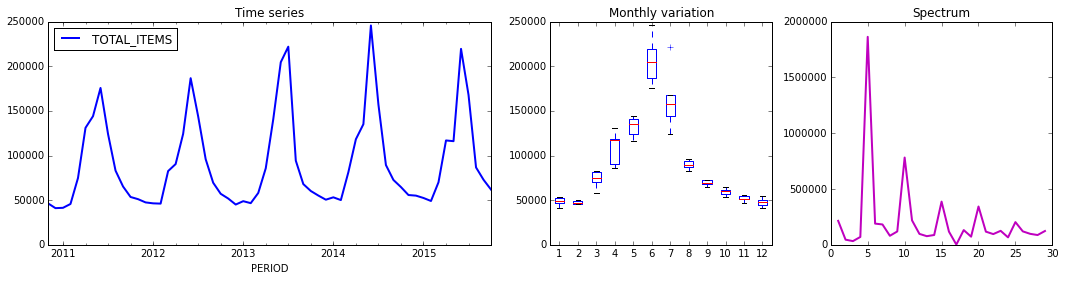

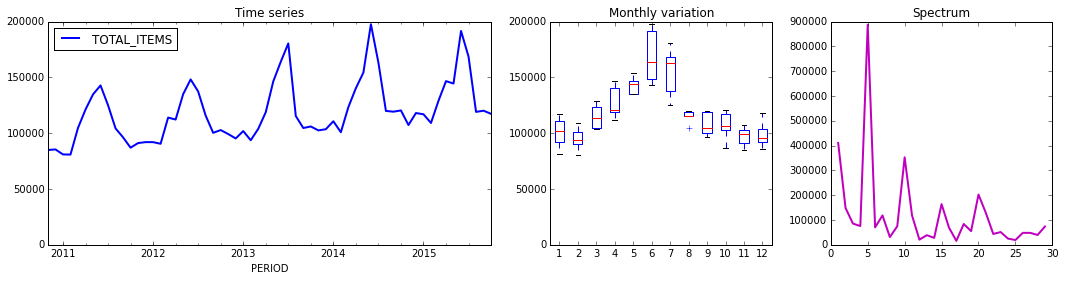

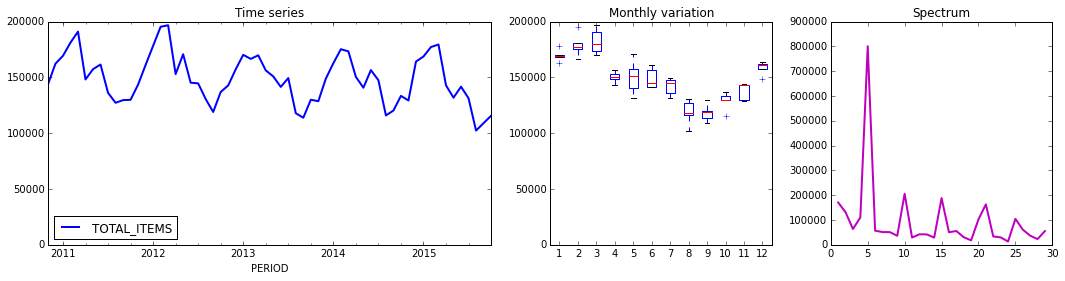

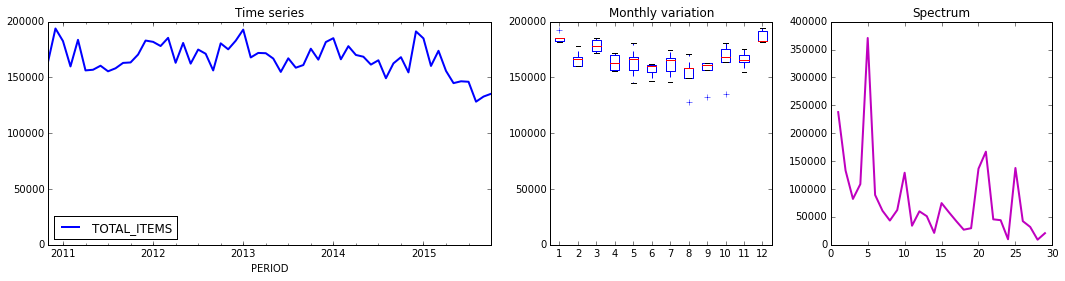

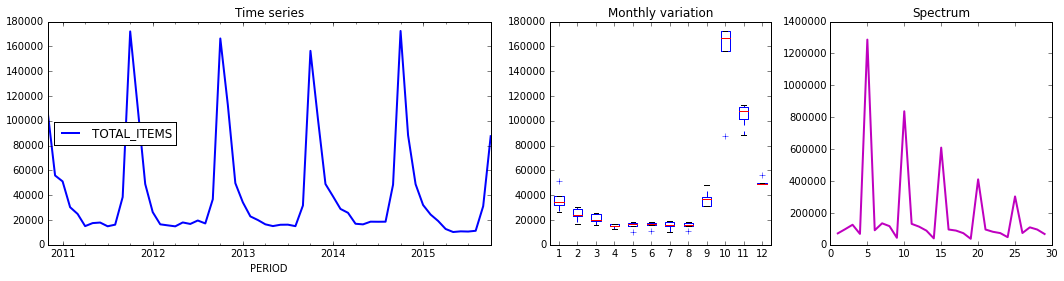

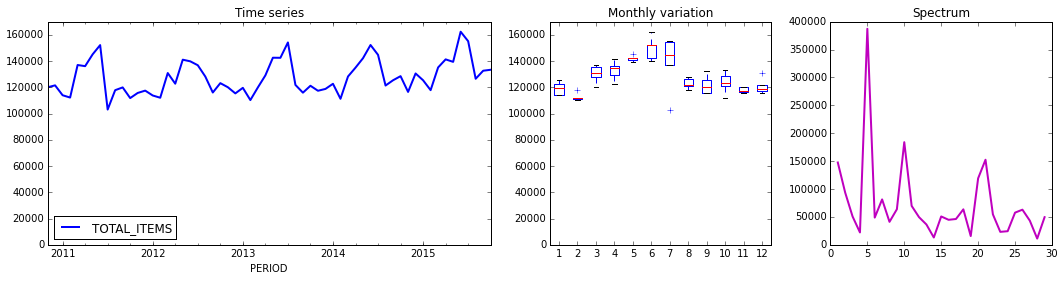

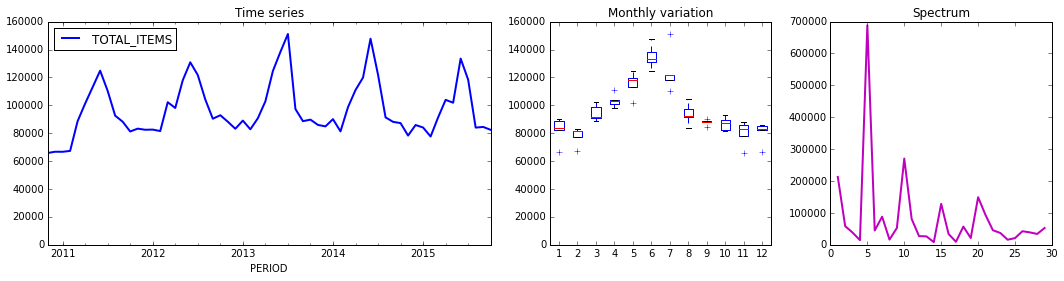

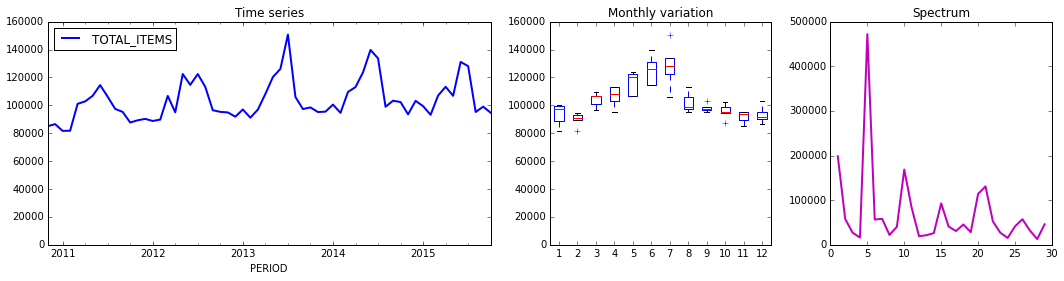

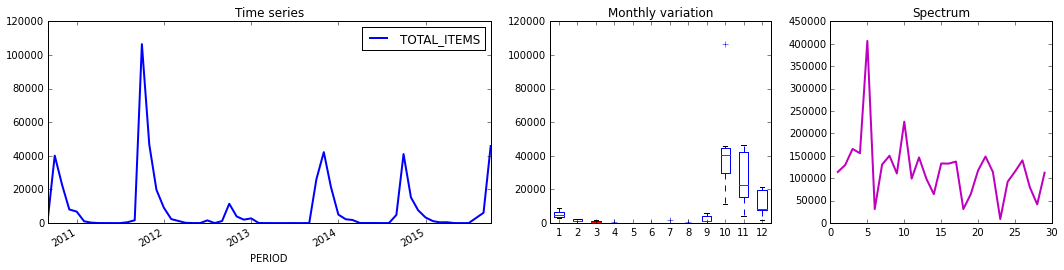

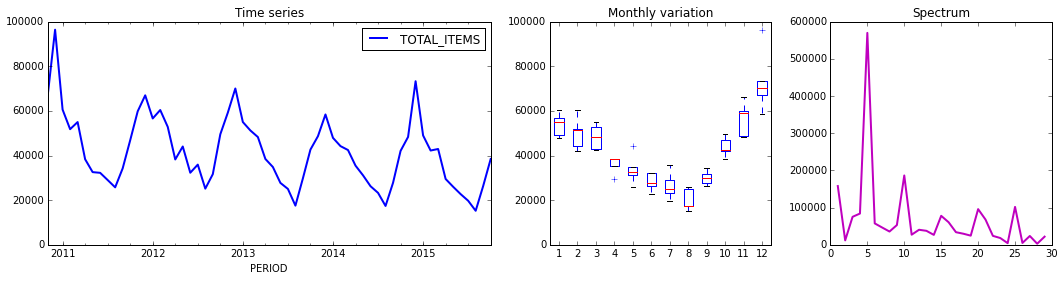

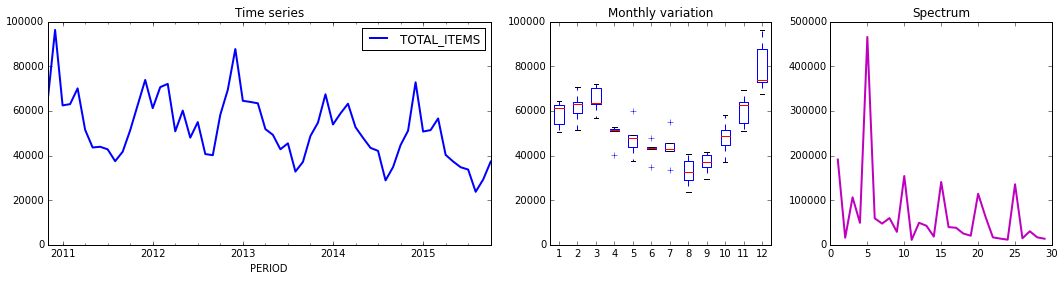

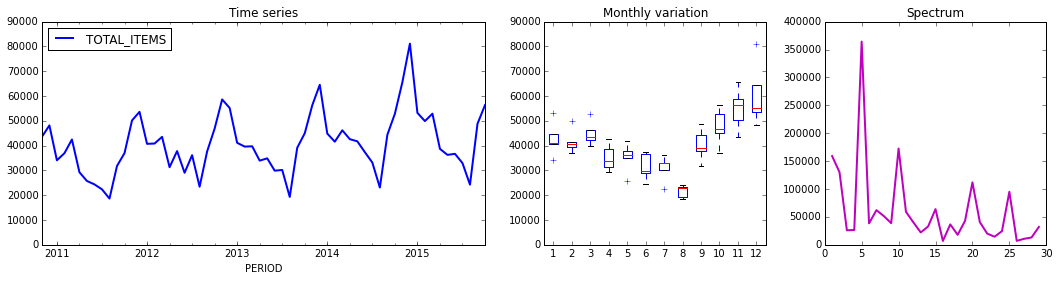

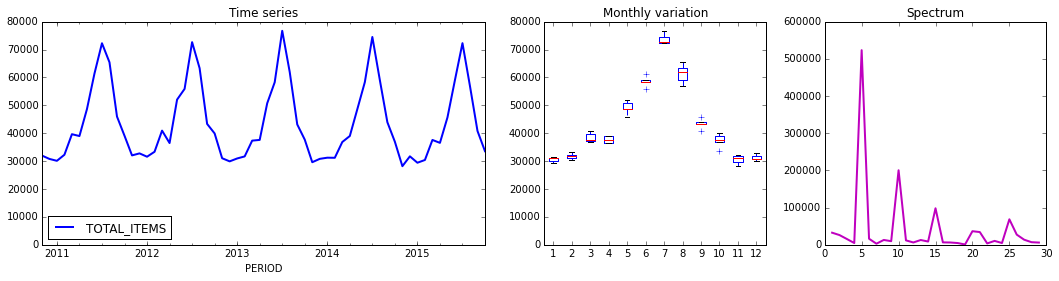

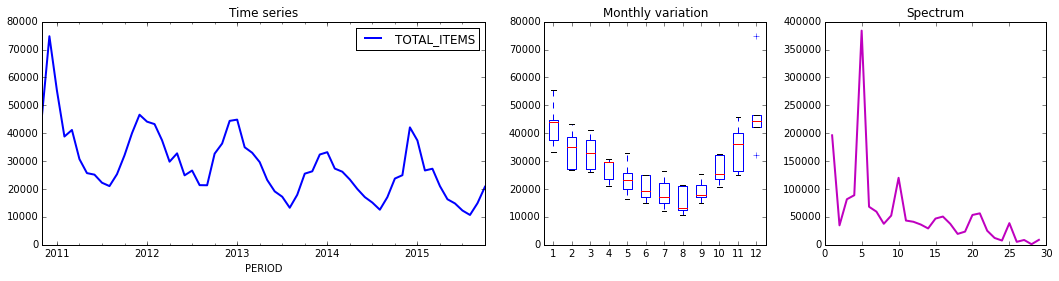

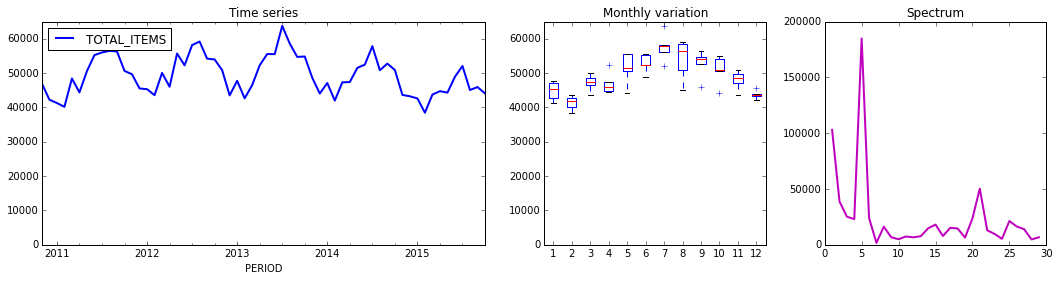

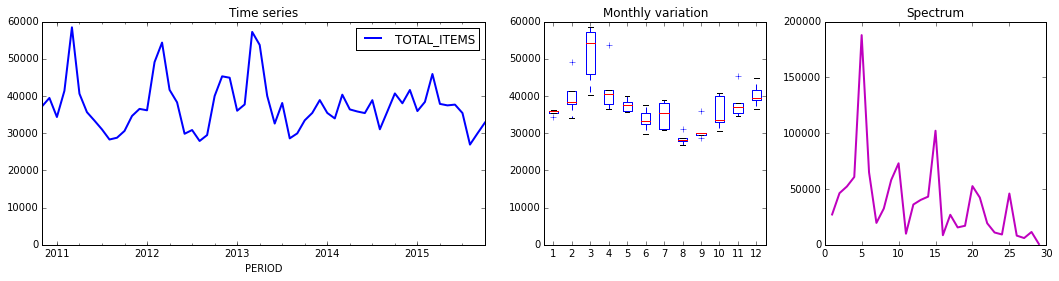

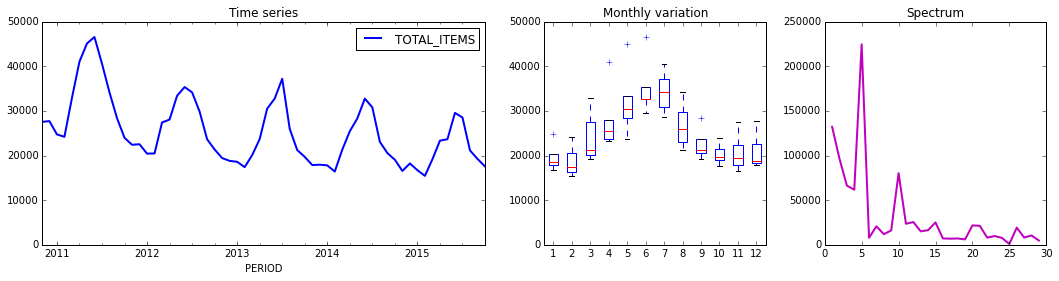

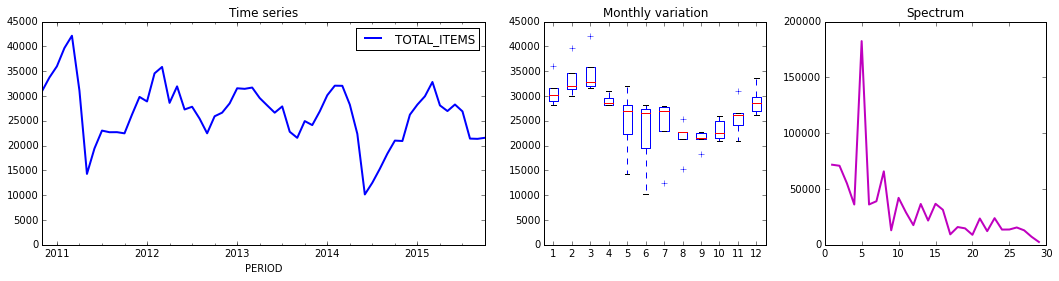

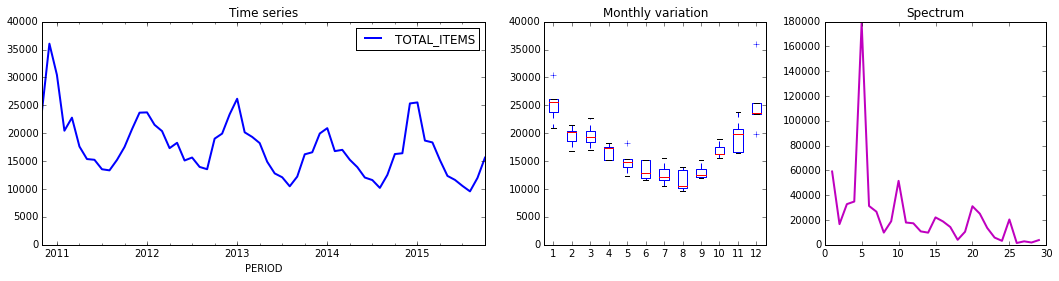

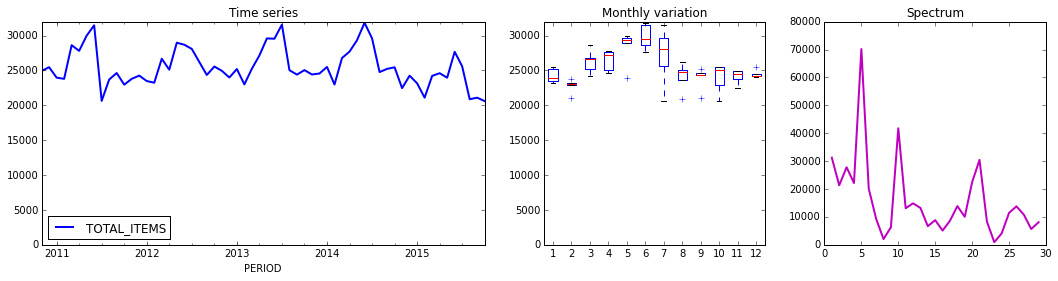

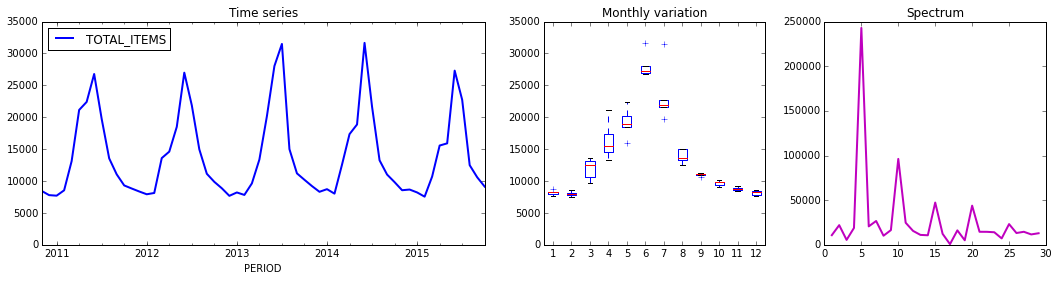

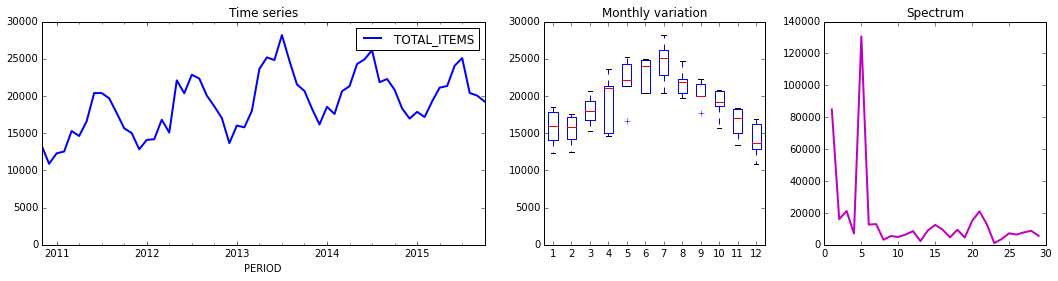

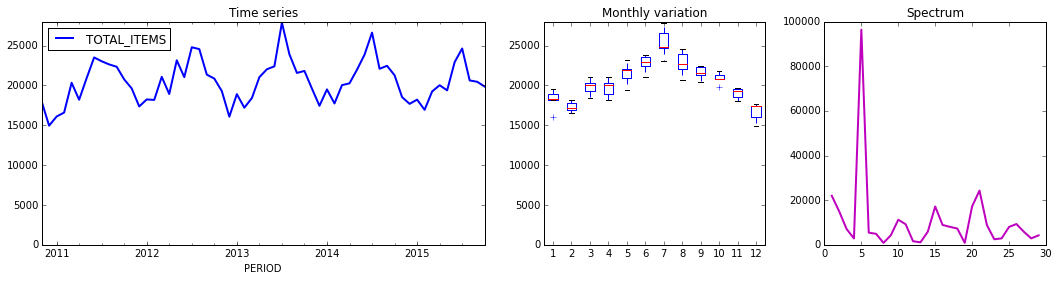

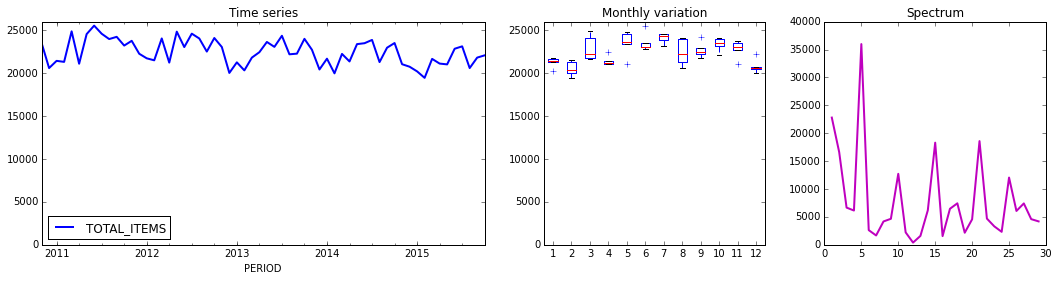

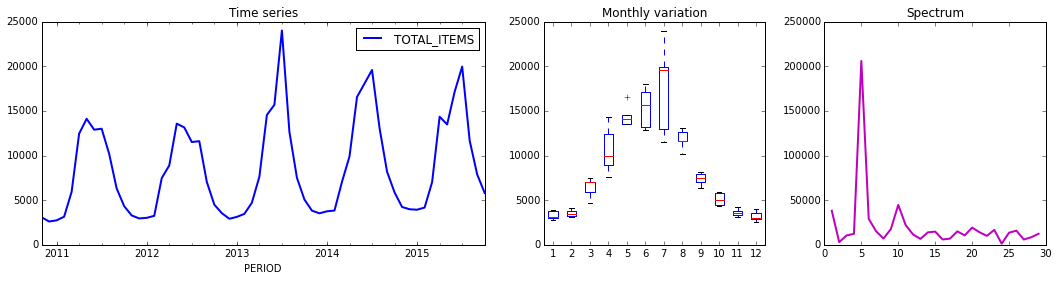

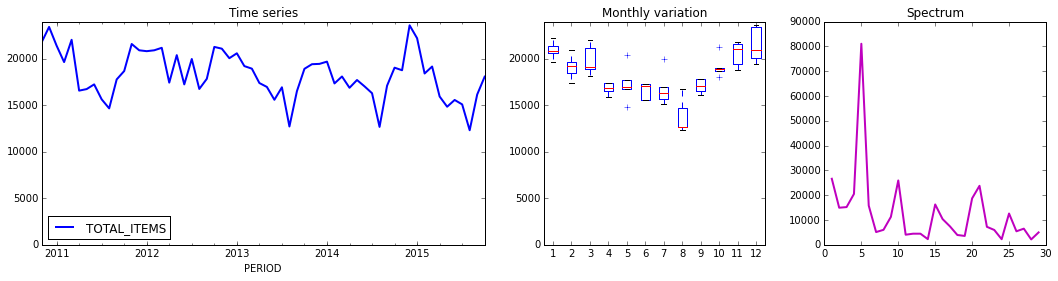

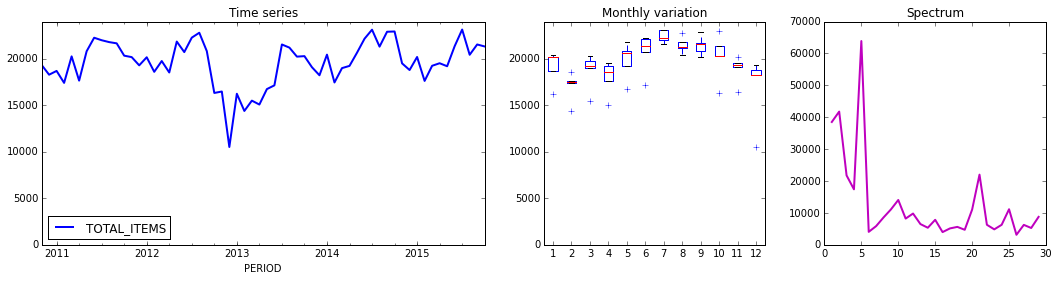

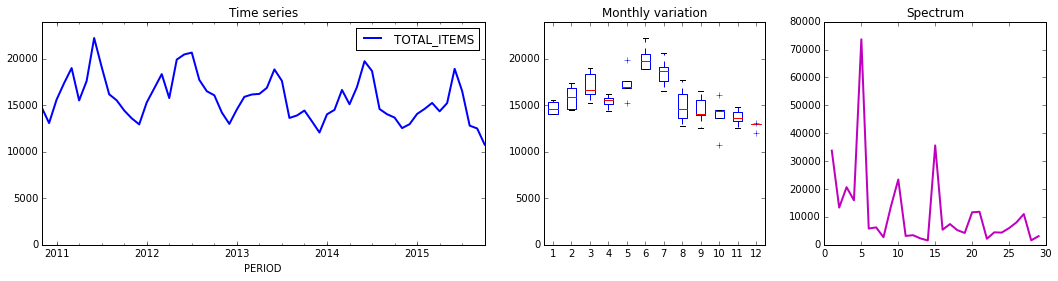

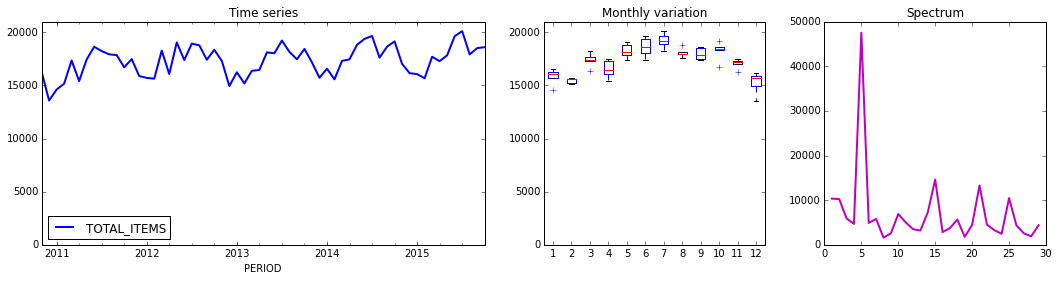

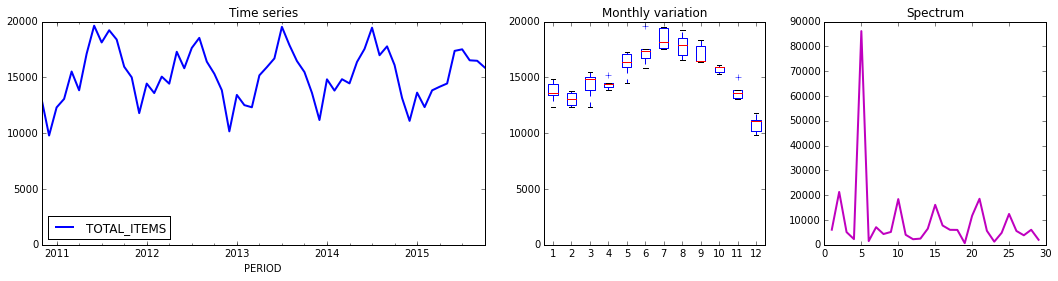

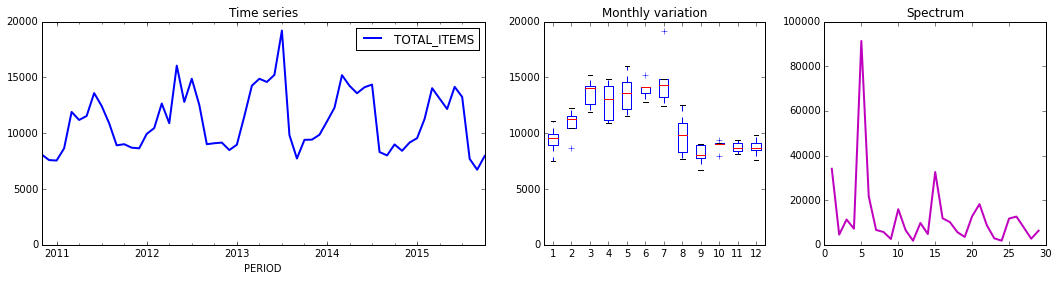

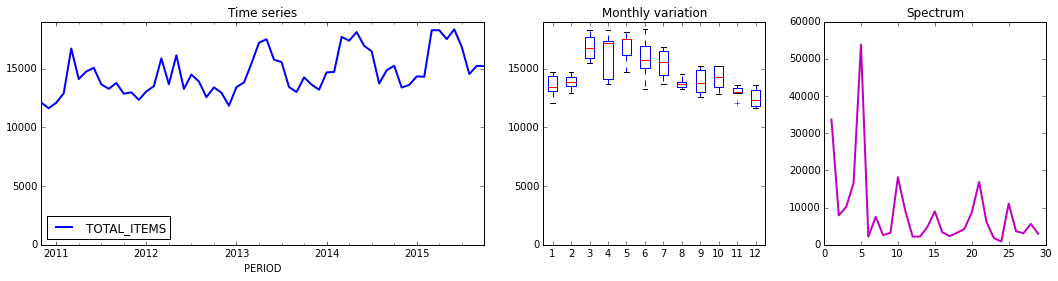

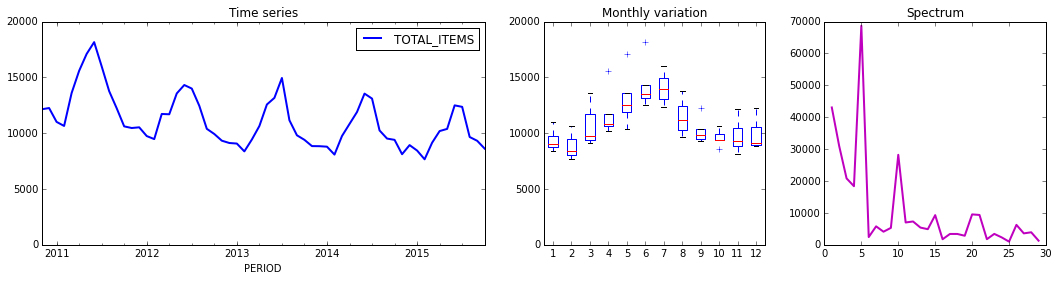

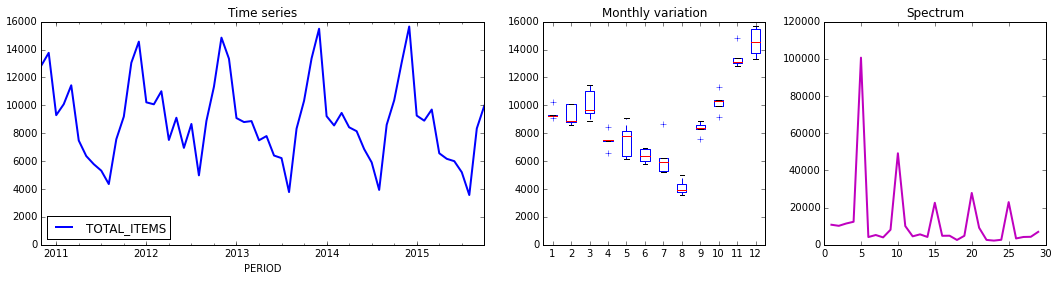

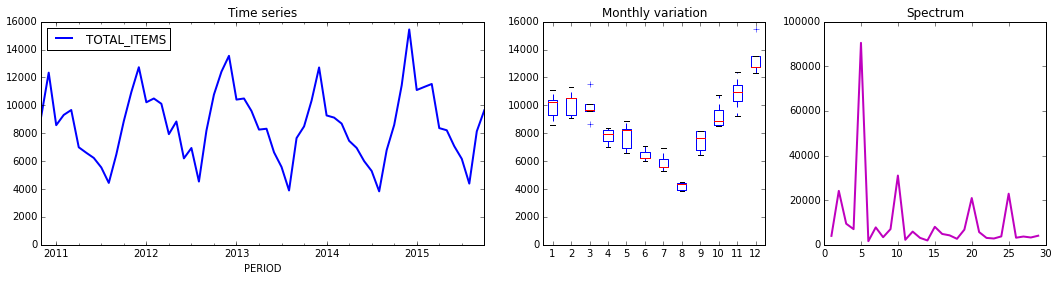

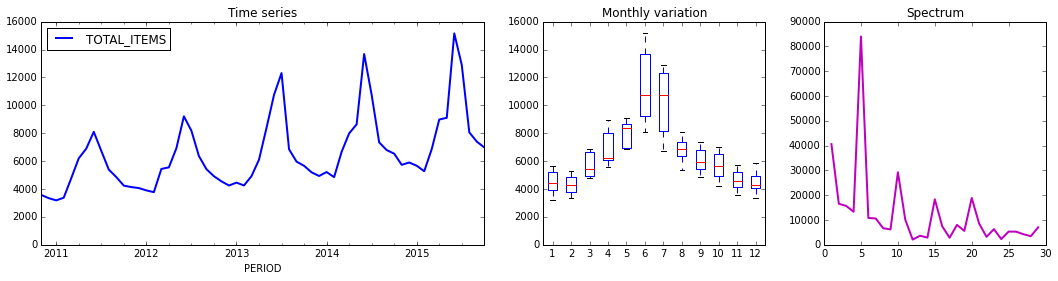

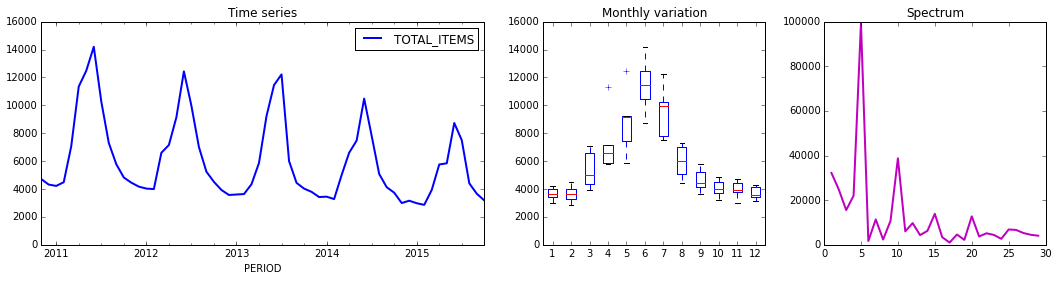

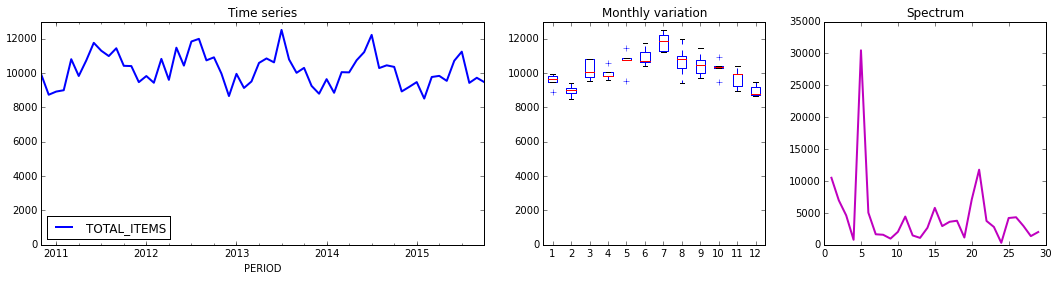

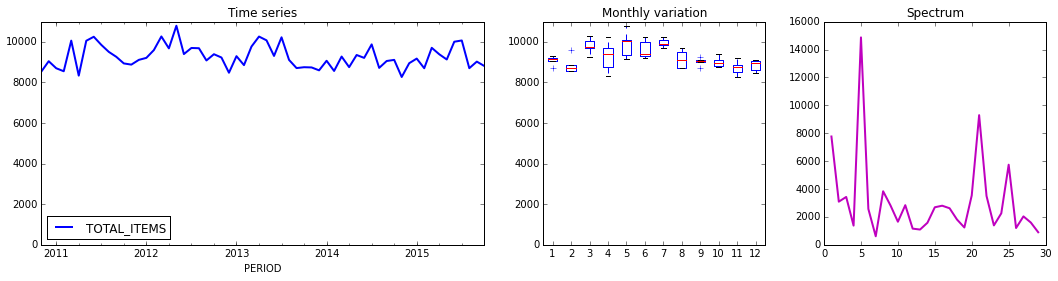

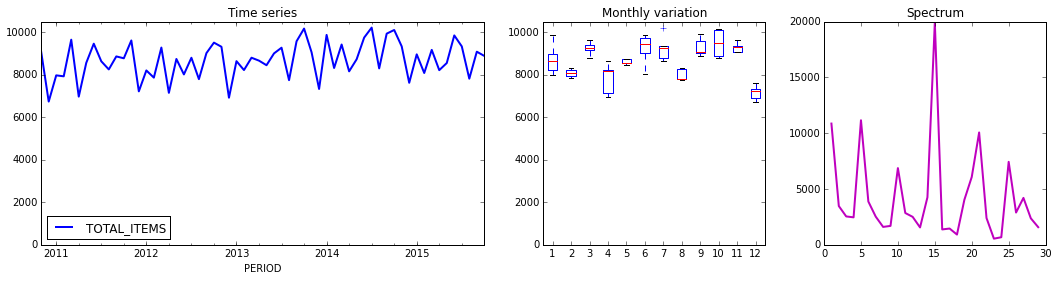

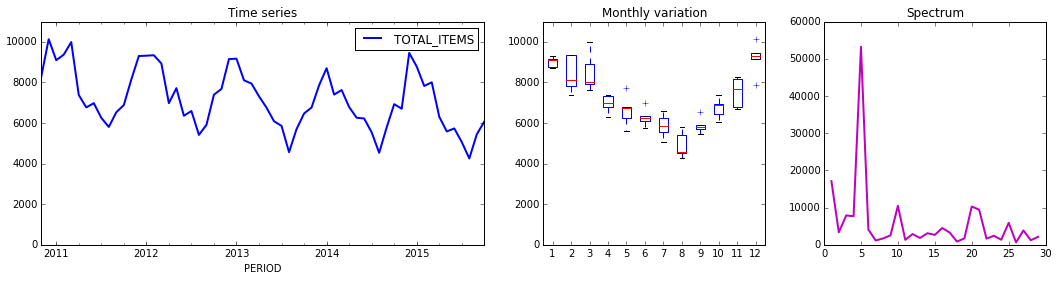

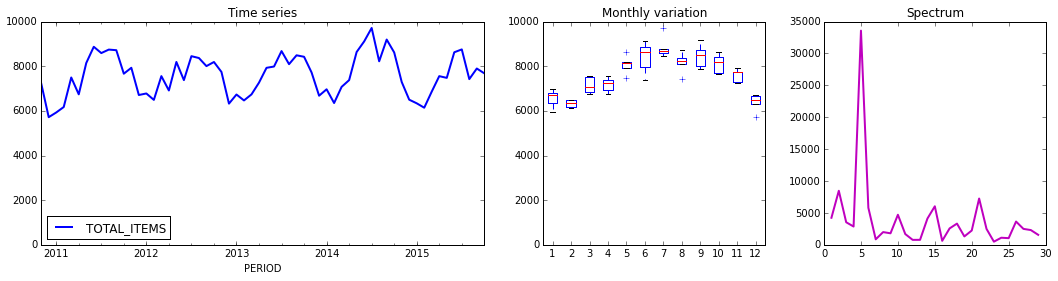

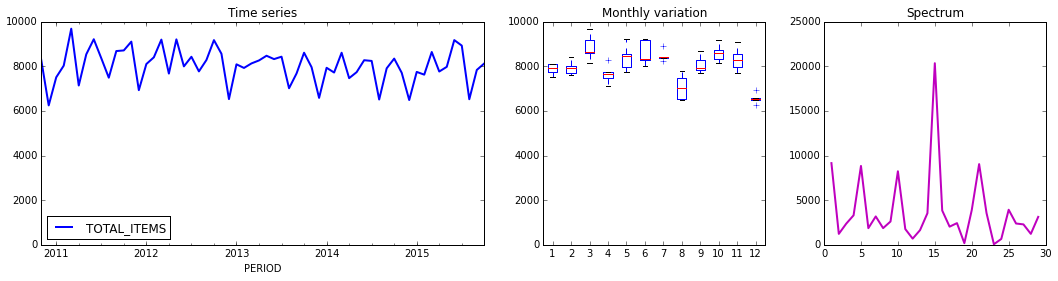

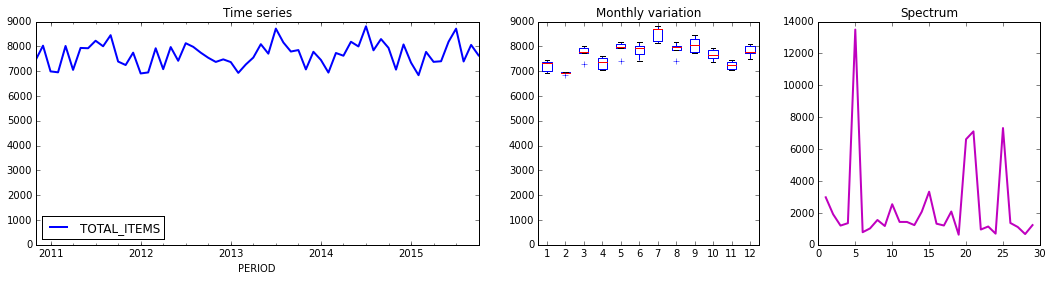

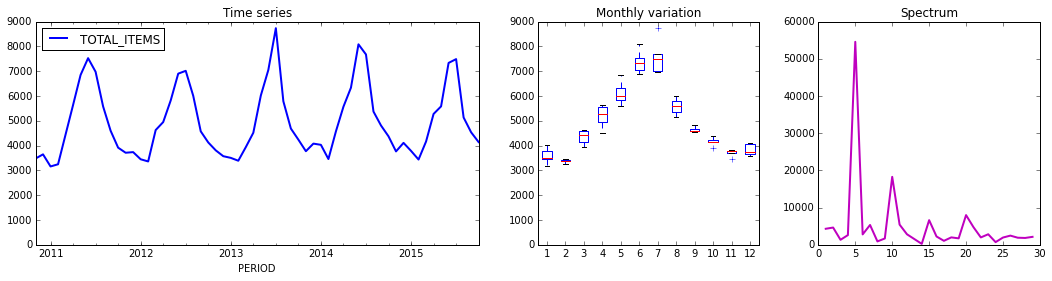

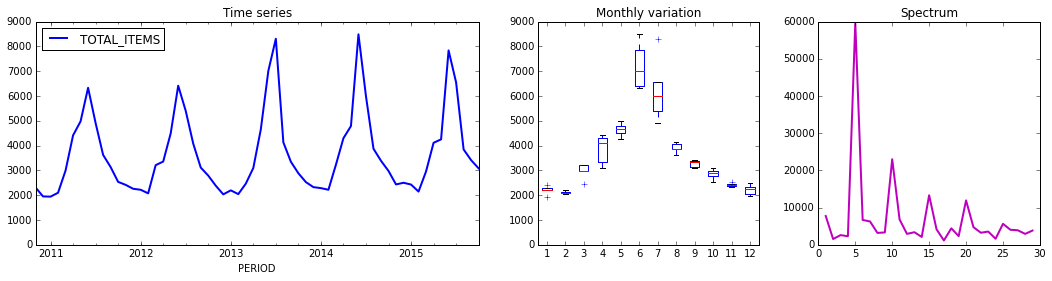

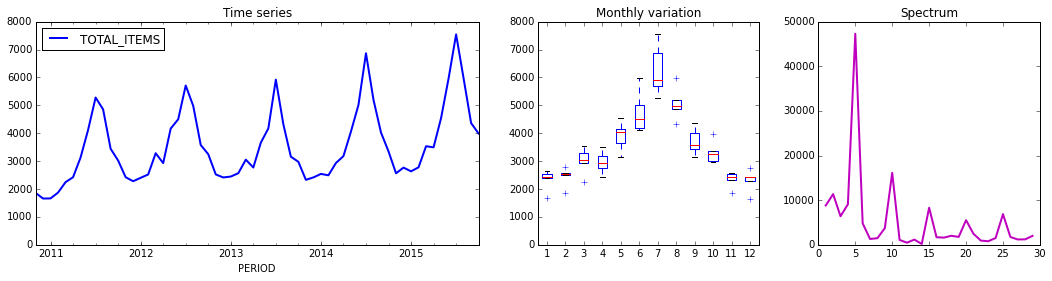

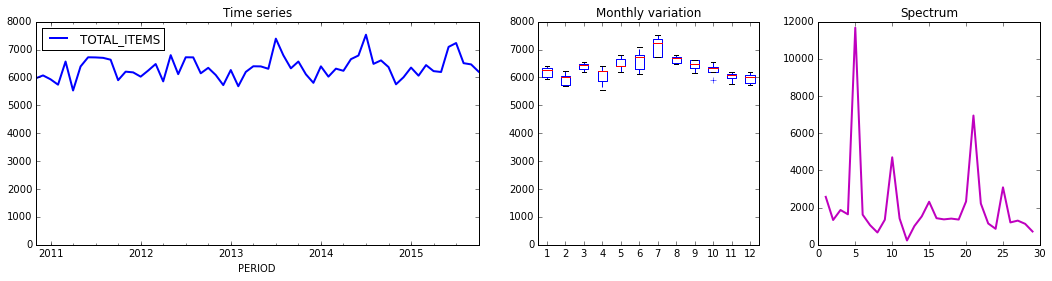

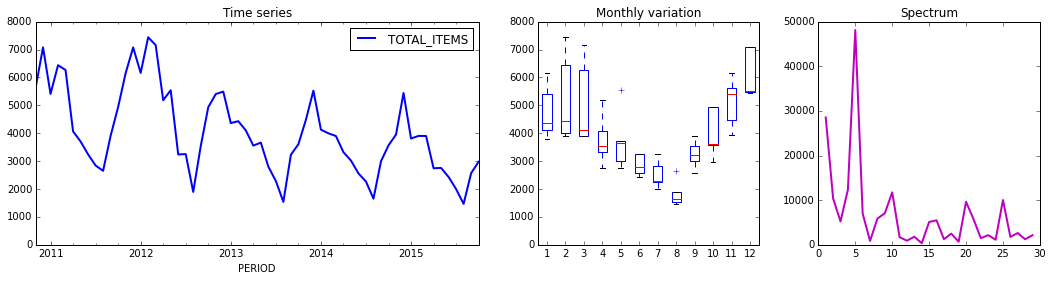

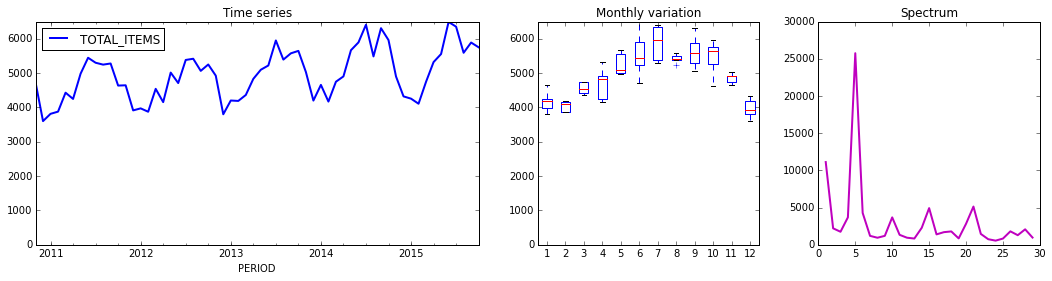

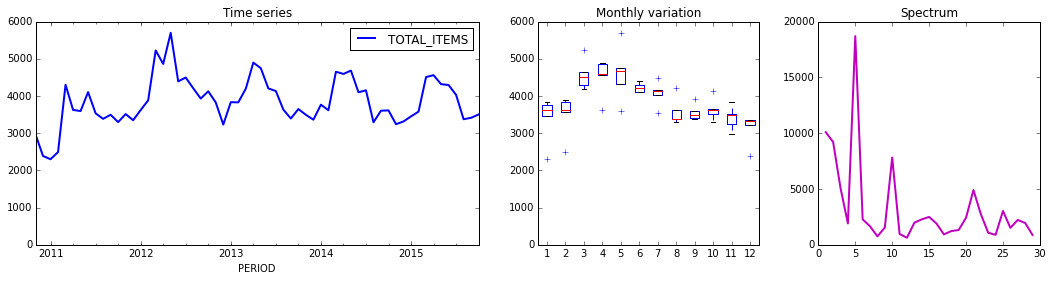

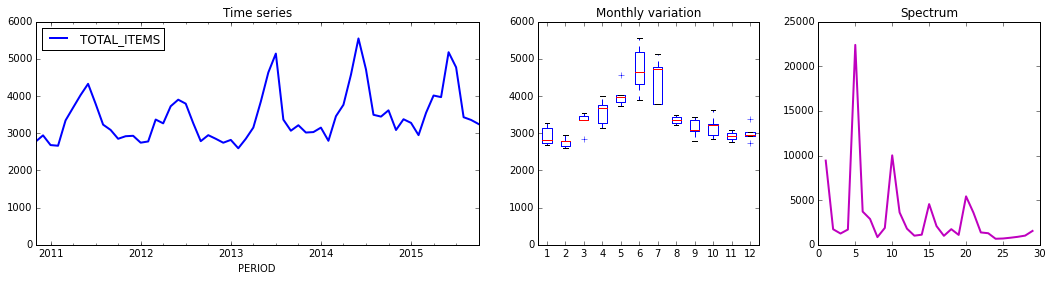

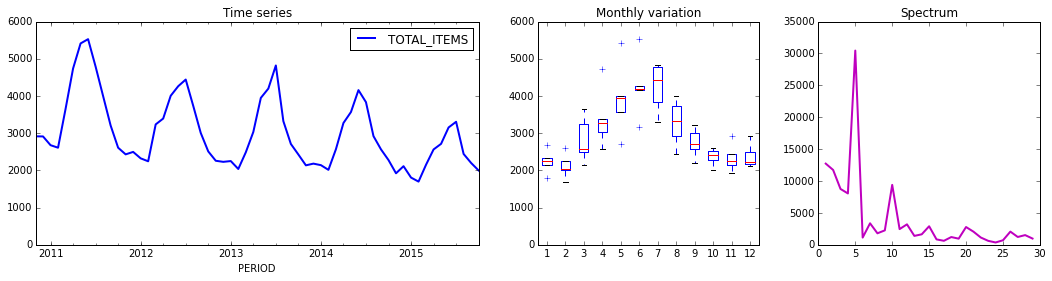

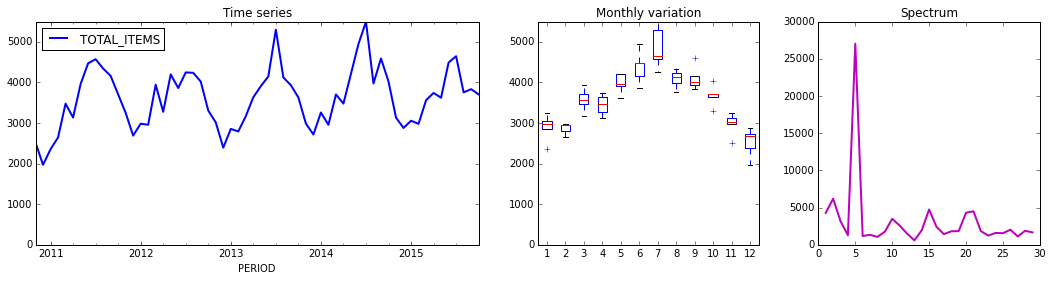

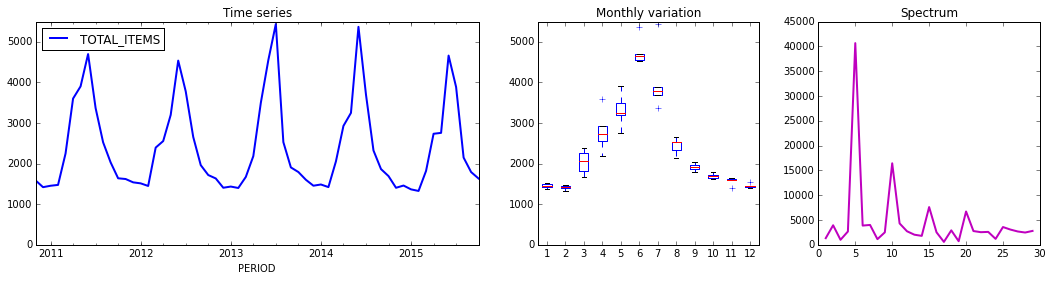

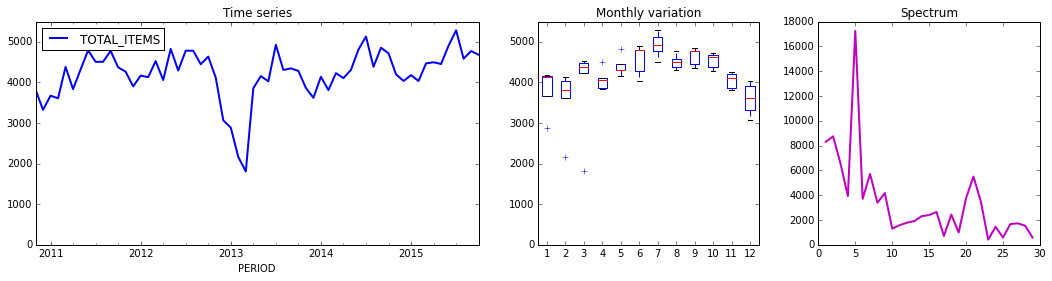

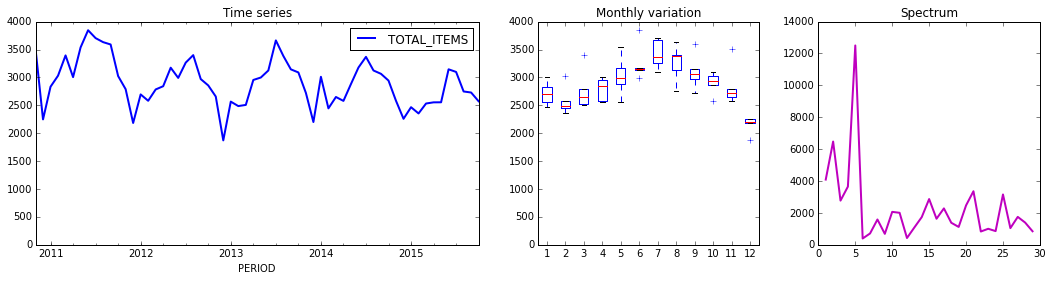

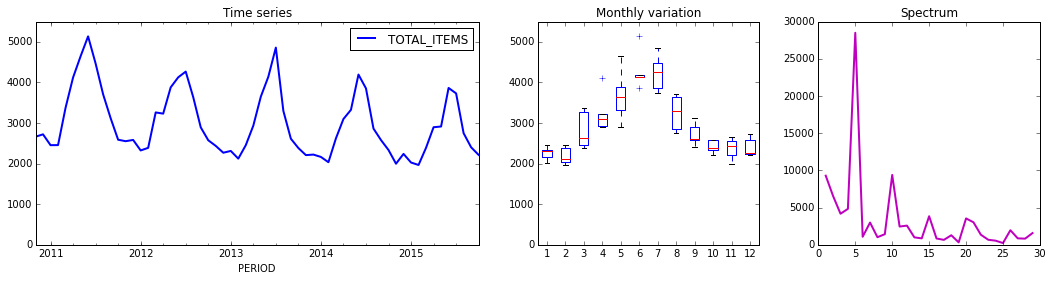

In [190]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False).index:
    if scores.ix[highscorer]['TOTAL_ITEMS']<5000:
        break
    plot_with_spectrum(df.ix[highscorer],highscorer)
    